## 0. Импортируем бибилиотеки. Описываем пользовательские функции

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import os
import numpy as np
import pandasql as ps
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier

from datetime import datetime
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, NuSVC, SVC

import optuna
from sklearn.model_selection import cross_val_score
import itertools


# Описываем пользовательские функции

# Функция для вывода confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Функция принимает фактическое и прогнощное значения и выводит ряд метрик качества модели
# можно указать порог, по умолчанию он равен 0.5
def metrics(fact, pred, trash=0.5):
    plot_confusion_matrix(confusion_matrix(fact, pred > trash), ['0','1'])
    print('precision:', precision_score(fact, pred > trash))
    print('recall:', recall_score(fact, pred > trash))
    print('f1_score:', f1_score(fact, pred > trash))    
    print('accuracy_score:', accuracy_score(fact, pred > trash))
    print('roc_auc:', roc_auc_score(fact, pred))
    

# Функция снижает размерность датасета за счет замены типа переменных без потери информации
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

# Функция принимает фактическое и прогнозное значения и определяет уровни фактического дефолта
# по децилям прогнозного дефолта
def badrate(fact, predict):
    fact = list(fact)
    if len(fact) != len(predict):
        print('Параметры должны иметь одинаковую размерность')
        return
    result = {}
    for i in range(0, 10):        
        result[i] = [0, 0, 0, 0]
    for i in range(0, len(predict)):
        number = int(predict[i]*10 // 1)
        result[number][0] += 1
        result[number][1] += fact[i] 
    for i in range(10):
        result[i][2] = result[i][0] / len(predict)
        result[i][3] = result[i][1] / result[i][0]
    return result

# функция вывода результатов работы функции badrate
def badrate_show(br):
    print('диапазон прогноза| доля значений | просрочка' )
    for key in br:
        print(f'{key/10}-{(key + 1)/10}          {round(br[key][2] * 100, 2)}%          {round(br[key][3] * 100, 2)}%')

## 1. Читаем исходные файлы, делим результат на отдельные датафреймы в зависимости от типов переменных

In [3]:
%%time
df = pd.DataFrame()

for filename in os.listdir('train_data'):
    full_name = 'train_data/' + filename
    current_df = pd.read_parquet(full_name)    
    df = pd.concat([df, current_df])
    print(full_name, 'обработан')
    print(df.shape)
    
df.set_index('id', inplace=True)
df = reduce_mem_usage(df)

train_data/train_data_0.pq обработан
(1974724, 61)
train_data/train_data_1.pq обработан
(4082029, 61)
train_data/train_data_10.pq обработан
(6378401, 61)
train_data/train_data_11.pq обработан
(8829031, 61)
train_data/train_data_2.pq обработан
(10909539, 61)
train_data/train_data_3.pq обработан
(13022131, 61)
train_data/train_data_4.pq обработан
(15086241, 61)
train_data/train_data_5.pq обработан
(17237149, 61)
train_data/train_data_6.pq обработан
(19413601, 61)
train_data/train_data_7.pq обработан
(21635846, 61)
train_data/train_data_8.pq обработан
(23878461, 61)
train_data/train_data_9.pq обработан
(26162717, 61)
Mem. usage decreased to 1696.65 Mb (86.1% reduction)
Wall time: 3min


In [4]:
print('Пропущенные значения:', df.isna().sum().sum())

Пропущенные значения: 0


Разделю все признаки на 3 категории: бинарные, бинаризированные и закодированные, 
для каждой категирии признаков буду применять разные способы формирования признаков итогового датасета

In [5]:
bin_col = []
enc_col = []
bool_col = []


for col in df.columns:
    if df[col].nunique() == 2:
        bool_col.append(col)
    elif col.startswith('enc_'):
        enc_col.append(col)
    elif col.startswith('pre_'):
        bin_col.append(col)

In [6]:
# Проверяем, есть ли среди бинарных переменных переменные близкие к постоянным
for cl in bool_col:    
    print(df[cl].value_counts())
    print(round(min(df[cl].sum()/df.shape[0], 1-df[cl].sum()/df.shape[0]), 4)*100)

pre_loans_total_overdue
0    26162716
1           1
Name: count, dtype: int64
0.0
is_zero_loans5
1    24035861
0     2126856
Name: count, dtype: int64
8.129999999999999
is_zero_loans530
1    21772900
0     4389817
Name: count, dtype: int64
16.78
is_zero_loans3060
1    25047143
0     1115574
Name: count, dtype: int64
4.26
is_zero_loans6090
1    25519933
0      642784
Name: count, dtype: int64
2.46
is_zero_loans90
1    25535248
0      627469
Name: count, dtype: int64
2.4
is_zero_util
1    18258067
0     7904650
Name: count, dtype: int64
30.209999999999997
is_zero_over2limit
1    24334366
0     1828351
Name: count, dtype: int64
6.99
is_zero_maxover2limit
1    22383950
0     3778767
Name: count, dtype: int64
14.44
pclose_flag
0    22259294
1     3903423
Name: count, dtype: int64
14.92
fclose_flag
0    20172292
1     5990425
Name: count, dtype: int64
22.900000000000002


In [12]:
# Переменную pre_loans_total_overdue можно удалить, так как она во всех записях, кроме одной, 
# принимает одинаковые значения
df.drop('pre_loans_total_overdue', axis=1, inplace=True)
bool_col.remove('pre_loans_total_overdue')

In [7]:
# Делаем подобную проверку в отношении бинаризированных переменных
for cl in bin_col:
    if df[cl].value_counts().iloc[0]/df.shape[0]*100 > .995:
        print(f'{cl}, уникальных значений: {df[cl].nunique()}, максимальная доля: {round(df[cl].value_counts().iloc[0]/df.shape[0]*100, 1)}%')

pre_since_opened, уникальных значений: 20, максимальная доля: 6.3%
pre_since_confirmed, уникальных значений: 18, максимальная доля: 18.8%
pre_pterm, уникальных значений: 18, максимальная доля: 17.0%
pre_fterm, уникальных значений: 17, максимальная доля: 23.7%
pre_till_pclose, уникальных значений: 17, максимальная доля: 18.8%
pre_till_fclose, уникальных значений: 16, максимальная доля: 27.1%
pre_loans_credit_limit, уникальных значений: 20, максимальная доля: 8.2%
pre_loans_next_pay_summ, уникальных значений: 7, максимальная доля: 67.9%
pre_loans_outstanding, уникальных значений: 5, максимальная доля: 79.9%
pre_loans_max_overdue_sum, уникальных значений: 4, максимальная доля: 92.0%
pre_loans_credit_cost_rate, уникальных значений: 14, максимальная доля: 26.8%
pre_loans5, уникальных значений: 13, максимальная доля: 99.5%
pre_loans530, уникальных значений: 20, максимальная доля: 97.7%
pre_loans3060, уникальных значений: 10, максимальная доля: 99.9%
pre_loans6090, уникальных значений: 5, мак

In [8]:
# Делаем подобную проверку в отношении закодированных переменных
for cl in enc_col:    
    print(f'{cl}, уникальных значений: {df[cl].nunique()}, максимальная доля: {round(df[cl].value_counts().iloc[0]/df.shape[0]*100, 1)}%')

enc_paym_0, уникальных значений: 4, максимальная доля: 92.3%
enc_paym_1, уникальных значений: 4, максимальная доля: 83.3%
enc_paym_2, уникальных значений: 4, максимальная доля: 79.1%
enc_paym_3, уникальных значений: 4, максимальная доля: 74.9%
enc_paym_4, уникальных значений: 4, максимальная доля: 70.7%
enc_paym_5, уникальных значений: 4, максимальная доля: 66.5%
enc_paym_6, уникальных значений: 4, максимальная доля: 61.4%
enc_paym_7, уникальных значений: 4, максимальная доля: 56.5%
enc_paym_8, уникальных значений: 4, максимальная доля: 52.9%
enc_paym_9, уникальных значений: 4, максимальная доля: 49.5%
enc_paym_10, уникальных значений: 4, максимальная доля: 51.5%
enc_paym_11, уникальных значений: 4, максимальная доля: 56.0%
enc_paym_12, уникальных значений: 4, максимальная доля: 60.6%
enc_paym_13, уникальных значений: 4, максимальная доля: 64.7%
enc_paym_14, уникальных значений: 4, максимальная доля: 66.8%
enc_paym_15, уникальных значений: 4, максимальная доля: 68.5%
enc_paym_16, уника

In [9]:
bool_col.insert(0, 'rn')
bin_col.insert(0, 'rn')
enc_col.insert(0, 'rn')

In [14]:
%%time
# сохраняю промежуточные результаты
df[bool_col].to_csv('bool_col.csv')
df[bin_col].to_csv('bin_col.csv')
df[enc_col].to_csv('enc_col.csv')

Wall time: 3min 57s


## 2. Поочередно обрабатываем датафреймы с разными типами переменных, формируем признаки для итогового датасета

### 2.1. Бинарные
Для каждого бинарного признака создадим 4 агрегированных признака:
1. для каждой заявки расчитаем долю кредитов в истории, для которых значение параметра = 1
2. минимальное значение параметра по заявкам из истории
3. максимальное значение параметра по заявкам из истории
4. значение бмнарного признака из последней заявки (т.к. последняя заявка содержит наиболее актуальную информацию о клиенте, полагаю, что она может иметь большую предсказательную силу)

Признаки 2 и 3 выглядят избыточными, так как они однозначно определяются по признаку 1.
Если они окажутся бесполезны, то будут отсеяны при отборе признаков.

In [11]:
# Запускаем, если был перерыв в работе и надо прочитать промежуточный файл
# Иначе переходим к следующей ячейке
bool_df = pd.read_csv('bool_col.csv')
bool_df.head()

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,1,1,1,1,1,1,1,1,1,0,0
1,0,2,1,1,1,1,1,1,1,1,0,0
2,0,3,1,1,1,1,1,0,1,1,1,1
3,0,4,0,1,1,1,1,1,1,1,0,0
4,0,5,1,1,1,1,1,1,1,1,0,0


In [17]:
# Запускаем, если не было перерыва в работе
bool_df = df[bool_col]
bool_df.reset_index(inplace=True)
bool_df.head()

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,1,1,1,1,1,1,1,1,1,0,0
1,0,2,1,1,1,1,1,1,1,1,0,0
2,0,3,1,1,1,1,1,0,1,1,1,1
3,0,4,0,1,1,1,1,1,1,1,0,0
4,0,5,1,1,1,1,1,1,1,1,0,0


In [18]:
# Напишем функцию, обрабатывающую бинарные переменные
def bool_processing(bool_df):
    # формируем таблицу со значениями последних взятых кредитов для каждого id
    bool_last = bool_df.loc[bool_df.groupby('id')['rn'].idxmax()]
    bool_last.set_index('id', inplace=True)


    # формируем сводную таблицу, строки - id, столбцы - для каждого бинарного признака mun, max, sum
    columns = list(bool_df.columns)
    columns.remove('id')
    pv = bool_df.pivot_table(index=['id'], 
                             values=columns, 
                             aggfunc=[np.min, np.max, np.sum,]
                            )

    # переименовываем столбцы
    pv.columns = [t[1] + '_' + t[0] for t in pv.columns]

    # удаляем мин и макс для номера заявки в истории
    pv.drop(['rn_amin', 'rn_sum'], axis=1, inplace=True)

    # делим значения сумм признаков на количество заявок в истории (оно в признаке rn_amax),
    # что бы получить долю
    for col in pv.columns:
        if col.endswith('_sum'):
            pv[col] = pv[col]/pv['rn_amax']

    # сохраняем результаты

    bool_processed = pd.concat([pv, bool_last], axis=1)
    bool_processed.drop('rn_amax', axis=1, inplace=True)
    return bool_processed


In [19]:
%%time

bool_processed = bool_processing(bool_df)
print(bool_processed.shape)
bool_processed.head()

(3000000, 41)
Wall time: 2min 14s


,fclose_flag_amin,is_zero_loans3060_amin,is_zero_loans5_amin,is_zero_loans530_amin,is_zero_loans6090_amin,is_zero_loans90_amin,is_zero_maxover2limit_amin,is_zero_over2limit_amin,is_zero_util_amin,pclose_flag_amin,...,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,1,1,1,0,0,0,0,...,1,1,1,1,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
2,0,0,1,0,0,1,0,1,0,0,...,1,1,1,1,1,0,1,1,1,1
3,0,1,1,1,1,1,0,0,0,0,...,1,1,1,1,1,0,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [20]:
# bool_processed.to_csv('bool_processed.csv')

### 2.2. Бинаризированные
Так как номера промежуткам назначены в случайном порядке, какие либо арифметические операции над ними, сравнения, определение динамики, полагаю, неприменимы.

Для каждой переменной посчитаю долю появления каждого значения в кредитной истории.

Т.к. последняя заявка содержит наиболее актуальную информацию о клиенте, полагаю, что она может иметь большую предсказательную силу, добавляю значения признаков из последней завки. Так как промежутки пронумерованы в случайном порядке, применяю к признакам, построенным по последенй заявке get_dummies.

In [3]:
%%time
# Запускаем, если был перерыв в работе и надо прочитать промежуточный файл
# Иначе переходим к следующей ячейке

bin_df = pd.read_csv('bin_col.csv')
bin_df.head()

Wall time: 24.4 s


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_util,pre_over2limit,pre_maxover2limit
0,0,1,18,9,2,3,16,10,11,3,...,2,11,6,16,5,4,8,16,2,17
1,0,2,18,9,14,14,12,12,0,3,...,2,11,6,16,5,4,8,16,2,17
2,0,3,18,9,4,8,1,11,11,0,...,2,8,6,16,5,4,8,15,2,17
3,0,4,4,1,9,12,16,7,12,2,...,2,4,6,16,5,4,8,16,2,17
4,0,5,5,12,15,2,11,12,10,2,...,2,4,6,16,5,4,8,16,2,17


In [21]:
# Запускаем, если не было перерыва в работе
bin_df = df[bin_col]
bin_df.reset_index(inplace=True)
bin_df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_util,pre_over2limit,pre_maxover2limit
0,0,1,18,9,2,3,16,10,11,3,...,2,11,6,16,5,4,8,16,2,17
1,0,2,18,9,14,14,12,12,0,3,...,2,11,6,16,5,4,8,16,2,17
2,0,3,18,9,4,8,1,11,11,0,...,2,8,6,16,5,4,8,15,2,17
3,0,4,4,1,9,12,16,7,12,2,...,2,4,6,16,5,4,8,16,2,17
4,0,5,5,12,15,2,11,12,10,2,...,2,4,6,16,5,4,8,16,2,17


In [22]:
def bin_processing(bin_df):
    bin_last = bin_df.loc[bin_df.groupby('id')['rn'].idxmax()]
    bin_last.set_index('id', inplace=True)
    bin_last.drop('rn', axis=1, inplace=True)

    bin_last = bin_last.astype(str)
    bin_last = pd.get_dummies(bin_last, drop_first= True)
    
    pv_rn = bin_df.pivot_table(index=['id'], 
                         values=['rn'], 
                         aggfunc=['count']
                        )
    pv_rn.columns = [t[1] + '_' + t[0] for t in pv_rn.columns]

    # создаем DataFrame для сохранения результатов
    bin_full_df = pd.DataFrame()

    # готовим список столбцов для обрабоки
    columns = list(bin_df.columns)
    columns.remove('id')
    columns.remove('rn')

    # для каждого столбца из списка создаем количество столбцов по количеству его уникальных значений 
    # и считаем количество появления этого уникального значения в истории по каждой заявке
    # все сохраняем в  bin_full_df 
    for cl in columns:
        cv = bin_df.groupby(['id', cl]). size().reset_index(name='count')

        pv = cv.pivot_table(index=['id'],
                                columns=[cl],
                                values=['count'],
                                aggfunc='sum',
                                fill_value = 0
                                )

        pv.columns = [str(t[1]) + '_' + cl for t in pv.columns]
        bin_full_df = pd.concat([bin_full_df, pv], axis = 1)

    # добавляем столбец с количеством кредитов в истории по каждой заявке
    bin_full_df = pd.concat([bin_full_df, pv_rn], axis = 1)

    # преобразовываем количество вхождения признака в долю - делим на количество кредитов в истории
    columns = list(bin_full_df.columns)
    columns.remove('rn_count')
    for cl in columns:
        bin_full_df[cl] = bin_full_df[cl]/bin_full_df['rn_count']

    # удяляем столбец с количеством кредитов в истории по каждой заявке, 
    # это значение попадет в итоговый датасет из датасета с бинарными признаками
    bin_full_df.drop('rn_count', axis=1, inplace=True)

    bin_processed = pd.concat([bin_full_df, bin_last], axis=1)
    return bin_processed

In [23]:
%%time

bin_processed = bin_processing(bin_df)
print(bin_processed.shape)
bin_processed.head()

(3000000, 509)
Wall time: 7min 7s


,0_pre_since_opened,1_pre_since_opened,2_pre_since_opened,3_pre_since_opened,4_pre_since_opened,5_pre_since_opened,6_pre_since_opened,7_pre_since_opened,8_pre_since_opened,9_pre_since_opened,...,pre_maxover2limit_18,pre_maxover2limit_19,pre_maxover2limit_2,pre_maxover2limit_3,pre_maxover2limit_4,pre_maxover2limit_5,pre_maxover2limit_6,pre_maxover2limit_7,pre_maxover2limit_8,pre_maxover2limit_9
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.1,0.100000,0.1,0.100000,0.200000,0.0,0.100000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.071429,0.142857,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.000000,0.2,0.066667,0.0,0.133333,0.066667,0.2,0.000000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False


In [28]:
# сохраняем результаты
bin_processed.to_csv('bin_processed.csv')

### 2.3. Закодированные

Для каждой переменной посчитаю долю появления каждого значения в кредитной истории.

Т.к. последняя заявка содержит наиболее актуальную информацию о клиенте, полагаю, что она может иметь большую предсказательную силу, добавляю значения признаков из последней завки. Так как промежутки пронумерованы в случайном порядке, применяю к признакам, построенным по последенй заявке get_dummies.

In [7]:
%%time
enc_df = pd.read_csv('enc_col.csv')
print(enc_df.shape)
enc_df.head()

(26162717, 31)
Wall time: 43.5 s


,id,rn,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,...,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur
0,0,1,0,0,3,3,3,3,3,3,...,3,4,3,3,3,4,1,3,4,1
1,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,3,4,1
2,0,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,2,3,1
3,0,4,1,0,0,0,0,0,0,0,...,3,4,3,3,3,4,1,3,1,1
4,0,5,0,0,0,0,0,0,0,3,...,3,4,3,3,3,4,1,3,4,1


In [24]:
# Запускаем, если не было перерыва в работе
enc_df = df[enc_col]
enc_df.reset_index(inplace=True)
enc_df.head()

,id,rn,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,...,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur
0,0,1,0,0,3,3,3,3,3,3,...,3,4,3,3,3,4,1,3,4,1
1,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,3,4,1
2,0,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,2,3,1
3,0,4,1,0,0,0,0,0,0,0,...,3,4,3,3,3,4,1,3,1,1
4,0,5,0,0,0,0,0,0,0,3,...,3,4,3,3,3,4,1,3,4,1


In [25]:
%%time

def enc_processing(enc_df):
    enc_last = enc_df.loc[enc_df.groupby('id')['rn'].idxmax()]
    enc_last.set_index('id', inplace=True)
    enc_last.drop('rn', axis=1, inplace=True)

    enc_last = enc_last.astype(str)
    enc_last = pd.get_dummies(enc_last, drop_first= True)

    # для каждой заявки определяем количество кредитов в истории
    pv_rn = enc_df.pivot_table(index=['id'], 
                             values=['rn'], 
                             aggfunc=['count']
                            )
    pv_rn.columns = [t[1] + '_' + t[0] for t in pv_rn.columns]

    # создаем DataFrame для сохранения результатов
    enc_full_df = pd.DataFrame()

    # готовим список столбцов для обрабоки
    columns = list(enc_df.columns)
    columns.remove('id')
    columns.remove('rn')

    # для каждого столбца из списка создаем количество столбцов по количеству его уникальных значений 
    # и считаем количество появления этого уникального значения в истории по каждой заявке
    # все сохраняем в  enc_full_df 
    for cl in columns:
        cv = enc_df.groupby(['id', cl]). size().reset_index(name='count')

        pv = cv.pivot_table(index=['id'],
                                columns=[cl],
                                values=['count'],
                                aggfunc='sum',
                                fill_value = 0
                                )

        pv.columns = [str(t[1]) + '_' + cl for t in pv.columns]
        enc_full_df = pd.concat([enc_full_df, pv], axis = 1)


    # добавляем столбец с количеством кредитов в истории по каждой заявке
    enc_full_df = pd.concat([enc_full_df, pv_rn], axis = 1)

    # преобразовываем количество вхождения признака в долю - делим на количество кредитов в истории
    columns = list(enc_full_df.columns)
    columns.remove('rn_count')
    for cl in columns:
        enc_full_df[cl] = enc_full_df[cl]/enc_full_df['rn_count']

    # удяляем столбец с количеством кредитов в истории по каждой заявке, 
    # это значение попадет в итоговый датасет из датасета с бинарными признаками
    enc_full_df.drop('rn_count', axis=1, inplace=True)
    
    enc_processed = pd.concat([enc_full_df, enc_last], axis=1)
    
    return enc_processed


enc_processed = enc_processing(enc_df)
print(enc_processed.shape)
enc_processed.head()

(3000000, 223)
Wall time: 5min 54s


,0_enc_paym_0,1_enc_paym_0,2_enc_paym_0,3_enc_paym_0,0_enc_paym_1,1_enc_paym_1,2_enc_paym_1,3_enc_paym_1,0_enc_paym_2,1_enc_paym_2,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
id,,,,,,,,,,,,,,,,,,,,,
0,0.900000,0.100000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.800000,0.000000,...,False,False,False,True,False,False,False,True,False,False
1,0.857143,0.071429,0.0,0.071429,0.642857,0.142857,0.0,0.214286,0.714286,0.071429,...,False,False,True,False,False,False,False,True,False,False
2,0.666667,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.666667,0.000000,...,False,False,True,False,False,False,False,True,False,False
3,1.000000,0.000000,0.0,0.000000,0.933333,0.000000,0.0,0.066667,0.933333,0.000000,...,False,False,False,True,False,False,False,True,False,False
4,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,...,False,False,True,False,False,False,False,True,False,False


In [27]:
# сохраняем результаты
enc_processed.to_csv('enc_processed.csv')

## 3. Собираем итоговый датафрейм

In [3]:
%%time
files = ['bin_processed.csv', 'enc_processed.csv', 'bool_processed.csv']
full_df = pd.DataFrame()

# читаем ранее сохраненные файлы и объединяем в один датафрейм
for file in files:
    tmp_df = pd.read_csv(file, index_col='id')
    full_df = pd.concat([full_df, tmp_df], axis = 1)
    print(file, 'ok')
    
# добавляем таргет
target = pd.read_csv('train_target.csv', index_col='id')
full_df = pd.concat([full_df, target], axis = 1)
full_df = reduce_mem_usage(full_df)

bin_processed.csv ok
enc_processed.csv ok
bool_processed.csv ok
Mem. usage decreased to 5730.63 Mb (48.0% reduction)
Wall time: 5min 28s


In [47]:
%%time
parts = [bin_processed, enc_processed, bool_processed]
full_df = pd.DataFrame()

# читаем ранее сохраненные файлы и объединяем в один датафрейм
for part in parts:    
    full_df = pd.concat([full_df, part], axis = 1)    
    
# добавляем таргет
target = pd.read_csv('train_target.csv', index_col='id')
full_df = pd.concat([full_df, target], axis = 1)
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 5730.63 Mb (44.9% reduction)
Wall time: 2min 2s


In [42]:
full_df.shape

(3000000, 774)

In [34]:
# сохраним полный датасет
full_df.to_csv('full_df_1.csv')

In [4]:
%%time
def remove_near_constant_col(full_df, threshold):
# удалим столбцы с высокой долей одного значения
    count = 0
    del_col = []
    
    for cl in full_df.columns:
        if full_df[cl].value_counts().iloc[0]/full_df.shape[0] > threshold:
            count += 1
            del_col.append(cl)       
    
    if count > 0:
        full_df.drop(del_col, axis=1, inplace=True)
    
    return full_df, count

full_df, count = remove_near_constant_col(full_df, 0.995)
if count > 0:
    print(f'Удалено {count} столбцов с высокой долей одного значения')

Удалено 223 столбцов с высокой долей одного значения
Wall time: 19.8 s


In [5]:
full_df.shape

(3000000, 551)

In [50]:
%%time
# сохраним в файл
full_df.to_csv('full_df_2.csv')



Wall time: 11min 22s


In [2]:
%%time
full_df = pd.read_csv('full_df_3.csv', index_col='id')
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 2838.13 Mb (50.8% reduction)
Wall time: 2min 32s


In [3]:
full_df.shape

(3000000, 363)

In [12]:
%%time
from sklearn.feature_selection import SelectKBest, chi2
fiels_selector = SelectKBest(chi2, k=100) 
fiels_selector.fit(full_df.drop('flag', axis=1),full_df['flag'])

target = full_df['flag']
full_df_250 = full_df[fiels_selector.get_feature_names_out()]
full_df_250.loc[:, 'flag'] = target

full_df_250.head()

Wall time: 2min 22s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,12_pre_since_opened,19_pre_since_opened,3_pre_fterm,10_pre_till_pclose,2_pre_loans_credit_limit,18_pre_loans_credit_limit,1_pre_loans_max_overdue_sum,4_pre_loans_credit_cost_rate,6_pre_loans_credit_cost_rate,3_pre_util,...,enc_loans_credit_type_5,fclose_flag_amin,is_zero_loans3060_amin,is_zero_loans530_amin,is_zero_loans6090_amin,is_zero_loans90_amin,pclose_flag_amin,rn,is_zero_util,flag
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.2,0.0,0.1,0.000000,0.000000,0.300000,0.0,0.000000,...,False,0,1,1,1,1,0,10,0,0
1,0.071429,0.0,0.0,0.0,0.0,0.000000,0.142857,0.714286,0.0,0.071429,...,False,0,0,0,0,0,0,14,1,0
2,0.333333,0.0,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.0,0.333333,...,False,0,0,0,0,1,0,3,0,0
3,0.066667,0.0,0.0,0.0,0.0,0.066667,0.000000,0.266667,0.0,0.066667,...,False,0,1,1,1,1,0,15,0,0
4,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,False,1,1,1,1,1,1,1,1,0


In [4]:
%%time
full_df = pd.read_csv('full_df_2.csv', index_col='id')
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 4311.56 Mb (49.2% reduction)
Wall time: 3min 51s


In [18]:
full_df.head()

,12_pre_since_opened,19_pre_since_opened,3_pre_fterm,10_pre_till_pclose,2_pre_loans_credit_limit,18_pre_loans_credit_limit,1_pre_loans_max_overdue_sum,4_pre_loans_credit_cost_rate,6_pre_loans_credit_cost_rate,3_pre_util,...,enc_loans_credit_type_5,fclose_flag_amin,is_zero_loans3060_amin,is_zero_loans530_amin,is_zero_loans6090_amin,is_zero_loans90_amin,pclose_flag_amin,rn,is_zero_util,flag
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.2,0.0,0.1,0.000000,0.000000,0.300000,0.0,0.000000,...,False,0,1,1,1,1,0,10,0,0
1,0.071429,0.0,0.0,0.0,0.0,0.000000,0.142857,0.714286,0.0,0.071429,...,False,0,0,0,0,0,0,14,1,0
2,0.333333,0.0,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.0,0.333333,...,False,0,0,0,0,1,0,3,0,0
3,0.066667,0.0,0.0,0.0,0.0,0.066667,0.000000,0.266667,0.0,0.066667,...,False,0,1,1,1,1,0,15,0,0
4,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,False,1,1,1,1,1,1,1,1,0


In [13]:
print(f'Доля дефолтов {round(full_df.flag.sum() / full_df.shape[0] * 100, 2)}%')

Доля дефолтов 3.55%


Наблюдаем сильный дисбаланс классов, учтем это при настройке параметров моделей

## 4. Проверим работу моделей по умолчанию
1. Подготовим выборки для обучения и проверки 70% train и 30% test
2. Из train выборки сделаем подвыборку, примерно 15% от всего датасета, на ней будем делать быструю проверку гипотез по моделям, подбор параметров, затем будем обучаться на всем train
3. используем разные классификаторы, выберем те, которые покажут лучший результата с параметрами по умолчанию для дальнейшей настройки
4. добавим в классификаторы параметры для балансировки классов

In [4]:
%%time
x_train, x_test, y_train, y_test = train_test_split(full_df.drop(['flag'], axis=1),
                                                    full_df['flag'],
                                                    test_size=0.3,
                                                    stratify=full_df['flag'],
                                                    random_state = 42)

x_train_sh, x_test_sh, y_train_sh, y_test_sh = train_test_split(x_train, 
                                                                y_train, 
                                                                test_size=0.8,
                                                                stratify=y_train,
                                                                random_state = 42)

Wall time: 19.7 s


In [8]:
%%time
importances = mutual_info_classif(x_train_sh, y_train_sh)
feature_importances = pd.Series(importances, x_train_sh.columns[0:len(x_train_sh.columns)])
feature_importances

Wall time: 24min 47s


In [13]:
best_features = feature_importances[feature_importances>0.0005].index
drop_features = feature_importances[feature_importances<=0.0005].index
len(best_features)

362

In [33]:
pkl_filename = "best_features.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_features, file)

In [14]:
%%time
full_df.drop(drop_features, axis=1).to_csv('full_df_3.csv')

Wall time: 7min 24s


In [15]:
%%time
full_df = pd.read_csv('full_df_3.csv', index_col='id')
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 2838.13 Mb (50.8% reduction)
Wall time: 1min 56s


In [ ]:
%%time
x_train, x_test, y_train, y_test = train_test_split(full_df.drop(['flag'], axis=1),
                                                    full_df['flag'],
                                                    test_size=0.3,
                                                    stratify=full_df['flag'],
                                                    random_state = 42)

x_train_sh, x_test_sh, y_train_sh, y_test_sh = train_test_split(x_train, 
                                                                y_train, 
                                                                test_size=0.8,
                                                                stratify=y_train,
                                                                random_state = 42)

In [4]:
%%time
x_train_sh.to_csv('x_train_sh.csv')
y_train_sh.to_csv('y_train_sh.csv')

Wall time: 1min 2s


In [7]:
len(y_train_sh)

420000

In [2]:
%%time
x_train_sh = pd.read_csv('x_train_sh.csv', index_col='id')
y_train_sh = pd.read_csv('y_train_sh.csv', index_col='id')
x_train_sh = reduce_mem_usage(x_train_sh)
y_train_sh = reduce_mem_usage(y_train_sh)

Mem. usage decreased to 396.94 Mb (50.6% reduction)
Mem. usage decreased to  3.60 Mb (43.8% reduction)
Wall time: 12.6 s


In [13]:
cw = list(class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train_sh), 
                                            y=y_train_sh.flag
                                           )
         )

In [32]:
%%time



classifiers = {}
classifiers['AdaBoostClassifier'] = [AdaBoostClassifier()]
classifiers['BaggingClassifier'] = [BaggingClassifier(n_jobs=7)]
classifiers['ExtraTreesClassifier'] = [ExtraTreesClassifier(n_jobs=7, class_weight='balanced')]
classifiers['GradientBoostingClassifier'] = [GradientBoostingClassifier()]
classifiers['RandomForestClassifier'] = [RandomForestClassifier(n_jobs=7, class_weight='balanced')]
classifiers['MLPClassifier'] = [MLPClassifier()]
classifiers['SGDClassifier'] =[SGDClassifier(loss='log_loss', n_jobs=7, class_weight='balanced')]
classifiers['XGBClassifier'] = [XGBClassifier(n_jobs=7)]
classifiers['LogisticRegression'] = [LogisticRegression(n_jobs=7, class_weight='balanced')]
classifiers['CatBoostClassifier'] = [CatBoostClassifier(task_type="GPU", devices='0:1', class_weights=cw)]

print('Start Modeling', datetime.now().strftime("%H:%M:%S"))

for cl in classifiers.keys():
    cv_score = cross_val_score(classifiers[cl][0],
                               x_train_sh,
                               y_train_sh,
                               n_jobs=-1,
                               cv=3, 
                               scoring="roc_auc", 
                               verbose=False
                              )
    classifiers[cl].append(cv_score)    
    print(datetime.now().strftime("%H:%M:%S"), cl, cv_score)

Start Modeling 09:56:49
09:58:47 AdaBoostClassifier [0.73301389 0.7333906  0.72880995]
10:05:19 BaggingClassifier [0.6040287  0.60398361 0.59400349]
10:13:39 ExtraTreesClassifier [0.67604606 0.68422303 0.67698934]
10:23:31 GradientBoostingClassifier [0.74074699 0.74458091 0.73945027]
10:25:34 RandomForestClassifier [0.68412086 0.68315287 0.68698515]
10:42:45 MLPClassifier [0.62786104 0.62768662 0.62691648]
10:43:13 SGDClassifier [0.73204254 0.72609803 0.72059361]
10:47:05 XGBClassifier [0.72619861 0.72690538 0.72830164]
10:47:27 LogisticRegression [0.73785448 0.73629357 0.73435665]
10:48:48 CatBoostClassifier [0.75124221 0.75206138 0.74930375]
Wall time: 51min 59s


1. Хорошие результаты по целевой метрике дают алгоритмы, реализующие градиентный бустинг на деревьях. Для дальнейшей настройки и оптимизации выберу CatBoostClassifier, так как он дает максимальный результат и быстро работает.
3. Так же попробую оптимизировать LogisticRegression. У нее по умолчанию хороший результат и, так как в основе другой алгоритм, оптимизация может дать больший прирост качества, чем для CatBoostClassifier. Кроме того, именно эта модель в банковской часто используется для решения задачи скоринга.
3. Так же попробую оптимизацию RandomForestClassifier. По моим наблюдениям с параметрами по умолчанию модель часто переобучается, а подбор параметров приводит к снижению переобучения и росту целевой метрики на тесте.

## 5. Настройка CatBoostClassifier

Определим оптимальные параметры

In [14]:
%%time

def objective(trial):    
    iterations = trial.suggest_int('iterations', 100, 800)
    learning_rate = trial.suggest_float ('learning_rate', 0.01, 0.15)    
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 5)    
    
    cbc = CatBoostClassifier(iterations=iterations,
                             learning_rate=learning_rate,
                             depth=depth,                             
                             l2_leaf_reg = l2_leaf_reg,
                             task_type="GPU",
                             devices='0:1',
                             class_weights=cw
                            )
    
    return cross_val_score(cbc,
                           x_train_sh,
                           y_train_sh,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-09-09 09:32:21,569] A new study created in memory with name: no-name-e4b22556-1113-4b37-809a-62d599a84095
[I 2023-09-09 09:36:13,785] Trial 0 finished with value: 0.7485788439189713 and parameters: {'iterations': 588, 'learning_rate': 0.029372855519862892, 'depth': 4, 'l2_leaf_reg': 1.1802820370750806}. Best is trial 0 with value: 0.7485788439189713.
[I 2023-09-09 09:39:35,364] Trial 1 finished with value: 0.7328534068716568 and parameters: {'iterations': 218, 'learning_rate': 0.09519034480555119, 'depth': 8, 'l2_leaf_reg': 2.0592358694679507}. Best is trial 0 with value: 0.7485788439189713.
[I 2023-09-09 09:40:40,040] Trial 2 finished with value: 0.7464000662192495 and parameters: {'iterations': 277, 'learning_rate': 0.037436915885285194, 'depth': 5, 'l2_leaf_reg': 1.0762255621665366}. Best is trial 0 with value: 0.7485788439189713.
[I 2023-09-09 09:42:04,515] Trial 3 finished with value: 0.7419734193914111 and parameters: {'iterations': 696, 'learning_rate': 0.017761117408481

roc_auc: 0.7511483422839328
Best hyperparameters: {'iterations': 766, 'learning_rate': 0.08429420090834064, 'depth': 3, 'l2_leaf_reg': 0.6332126485392617}
Wall time: 2h 26min 16s


Обучим модель с лучшими параметрами на всем train, посмотрим на качество, сохраним в файл

precision: 0.07573594191451226
recall: 0.7026273760686437
f1_score: 0.1367334377456686
accuracy_score: 0.6852088888888889
roc_auc: 0.759846766111592


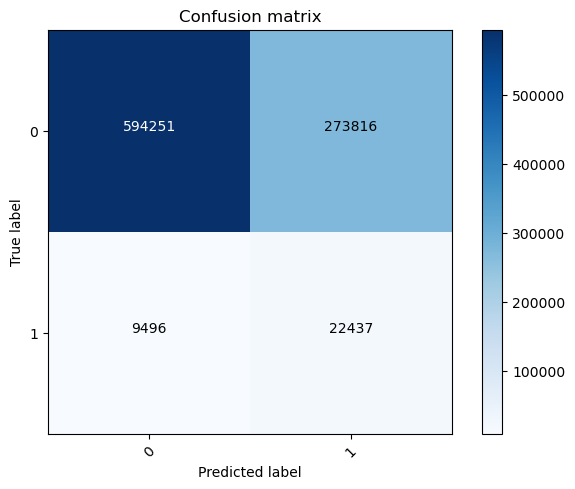

In [17]:
cat_grid_model = CatBoostClassifier(**trial.params,
                                    task_type="GPU",
                                    devices='0:1',
                                    class_weights=cw,
                                   )

cat_grid_model.fit(x_train,
                   y_train,
                   verbose = False
                  )

test_pred = cat_grid_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [20]:
br = badrate(y_test, test_pred)
badrate_show(br)

диапазон прогноза| доля значений | просрочка
0.0-0.1          3.37%          0.27%
0.1-0.2          14.91%          0.54%
0.2-0.3          17.44%          1.12%
0.3-0.4          16.5%          1.91%
0.4-0.5          14.86%          3.05%
0.5-0.6          12.8%          4.65%
0.6-0.7          10.3%          6.87%
0.7-0.8          6.81%          10.27%
0.8-0.9          2.79%          15.8%
0.9-1.0          0.21%          23.22%


Видим, что в 10% объектов с минимальной предсказанной вероятностью дефолта реальный уровень дефолта = 0,27%, а в 10% объектов с максимальной предсказанной вероятностью дефолта реальный уровень дефолта = 23,22%

Кроме того видим, что этот рост идет по всем бакетам - по мере роста предсказанных вероятностей дефолта растет реальный уровень дефолта.

Это, в дополнение к метрикам качества, подтверждает, что модель обладает способностью разделять плохих и хороших клиентов.

+ Достигнуто целевое качество модели
+ Уровни BadRate подтверждают предсказательную силу модели

Сохраним данную модель в файл.

In [34]:
# Сохраняем модель и набор столбцов в файл
import pickle
pkl_filename = "catboost_allfeatures_score76.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump([cat_grid_model, list(x_train_sh.columns)], file)

In [5]:
%%time
with open('catboost_allfeatures_score76.pkl', 'rb') as f:    
    best_model = pickle.load(f)
    
    
test_pred = best_model[0].predict_proba(x_test)[:,1]
train_pred = best_model[0].predict_proba(x_train)[:,1]

Wall time: 1min 33s


precision: 0.1322529584683802
recall: 0.27473146901324647
f1_score: 0.17855252981642042
accuracy_score: 0.9103088888888888
roc_auc: 0.759846766111592


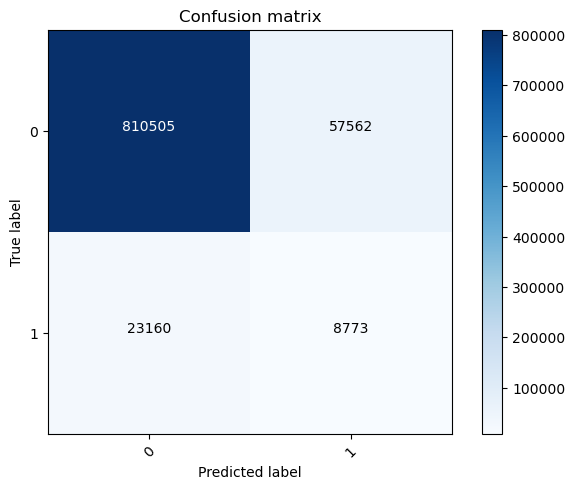

In [6]:
metrics(y_test, test_pred, trash=0.73)

## 6. Настройка LogisticRegression

precision: 0.07359073518482838
recall: 0.6698086618858234
f1_score: 0.13261165412718046
accuracy_score: 0.6891077777777778
roc_auc: 0.7428192676351697
Wall time: 4min 33s


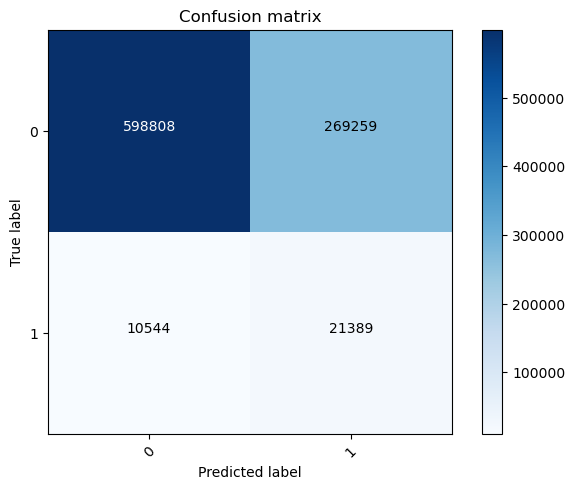

In [31]:
%%time

# Обучим модель с параметрами по умолчанию (кроме class_weight)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced')
lr_model.fit(x_train, y_train)

test_pred = lr_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

Попробуем подобрать оптимальные параметры

In [8]:
%%time

from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(n_jobs=7, class_weight='balanced')

parameters = [
              {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1]}            
             ]



grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 3,
                           verbose=0)

grid_search.fit(x_train_sh, y_train_sh)

pred_test = grid_search.best_estimator_.predict_proba(x_test)[:,1]
print('test roc_auc_score:', roc_auc_score(y_test, pred_test))

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be 

test roc_auc_score: 0.7448614298339695
Wall time: 41min 22s


Значение метрики незначительно улучшилось, но, по прежнему, ниже целевого.

Обучим модель с подобранными параметрами на большей части датасета.

In [33]:
lr_model = LogisticRegression(**grid_search.best_estimator_.get_params())
lr_model.fit(x_train, y_train)

test_pred = lr_model.predict_proba(x_test)[:,1]
print('test roc_auc_score:', roc_auc_score(y_test, test_pred))

test roc_auc_score: 0.7462688677571198


precision: 0.0746323439449923
recall: 0.6685873547740582
f1_score: 0.13427588505732668
accuracy_score: 0.6941088888888889
roc_auc: 0.7462688677571198


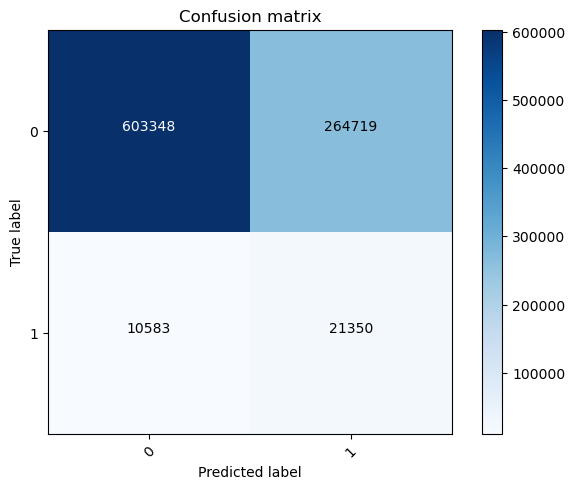

In [36]:
metrics(y_test, test_pred)

In [ ]:
badrate_show(badrate(y_test, test_pred))

Метрика еще немного подросла. Она, по прежнему, ниже целевого значения, но очень близка к нему.

In [37]:
# Сохраняем модель в файл
import pickle
pkl_filename = "lr_model_allfeatures_score746.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_model, file)

## 7. Настройка RandomForestClassifier

In [38]:
%%time

# Обучим модель с параметрами по умолчанию (кроме class_weight)

rf_model = RandomForestClassifier(n_jobs=7, class_weight='balanced')
rf_model.fit(x_train_sh, y_train_sh)

test_pred = rf_model.predict_proba(x_test)[:,1]
print('test roc_auc_score:', roc_auc_score(y_test, test_pred))

test roc_auc_score: 0.6895737826797295
Wall time: 1min 43s


In [21]:
%%time

# Пробуем подбор параметров при помощи optuna

import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):    
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)    
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    clf = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 min_samples_split = min_samples_split,
                                 criterion = criterion,
                                 class_weight='balanced',
                                 n_jobs=7
                                )
    
    return cross_val_score(clf,
                           x_train, 
                           y_train,
                           n_jobs=7,
                           cv=3, scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-20 20:07:02,616] A new study created in memory with name: no-name-e749bc57-548a-4618-85e1-044237f230a6
[I 2023-08-20 20:09:05,359] Trial 0 finished with value: 0.7277306779125291 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_leaf': 360, 'min_samples_split': 88, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.7277306779125291.
[I 2023-08-20 20:10:10,416] Trial 1 finished with value: 0.7049951224818738 and parameters: {'n_estimators': 90, 'max_depth': 5, 'min_samples_leaf': 283, 'min_samples_split': 17, 'criterion': 'gini', 'max_features': 'auto'}. Best is trial 0 with value: 0.7277306779125291.
[I 2023-08-20 20:12:05,015] Trial 2 finished with value: 0.7283789123157544 and parameters: {'n_estimators': 76, 'max_depth': 15, 'min_samples_leaf': 316, 'min_samples_split': 65, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7283789123157544.
[I 2023-08-20 20:12:27,226] Trial 3 finished with value: 0.697

roc_auc: 0.7324110583910947
Best hyperparameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_leaf': 139, 'min_samples_split': 48, 'criterion': 'entropy', 'max_features': 'log2'}
Wall time: 3h 48min 28s


Обучим модель на всем train датасете

precision: 0.08110964953490557
recall: 0.5406632637083895
f1_score: 0.14105795508858504
accuracy_score: 0.7663744444444445
roc_auc: 0.7339573866963691
Wall time: 4min 14s


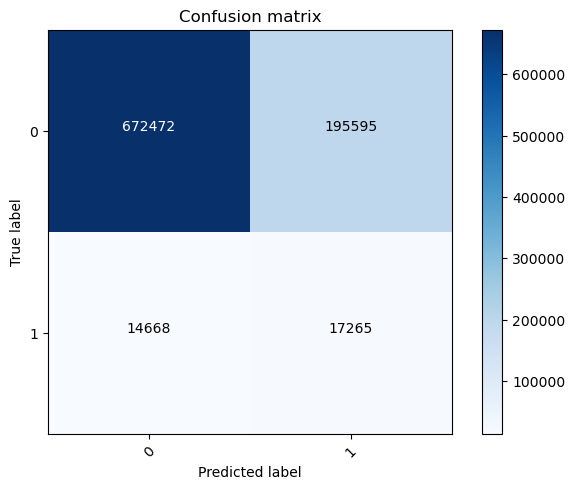

In [41]:
%%time

rf_model = RandomForestClassifier(**trial.params,
                                  class_weight='balanced',
                                  n_jobs=7                                  
                                 )
rf_model.fit(x_train, y_train)
test_pred = rf_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [ ]:
badrate_show(badrate(y_test, test_pred))

Так как RF склонна к переобучению, проверю метрики на train

precision: 0.10871923918431703
recall: 0.7329315921566523
f1_score: 0.18935112306956167
accuracy_score: 0.7773371428571428
roc_auc: 0.8407660386861393


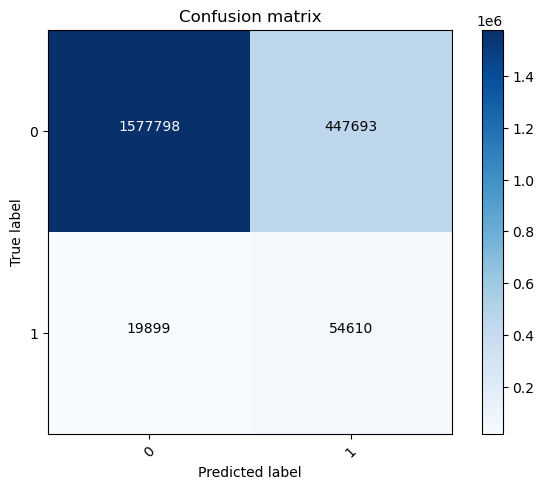

In [46]:
train_pred = rf_model.predict_proba(x_train)[:,1]
metrics(y_train, train_pred)

Модель сильно переобучена, это может помешать использовать ее дальше в ансамбле моделей


In [42]:
# Сохраняем модель в файл
import pickle
pkl_filename = "rf_model_allfeatures_score734.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)

За счет подбора параметров удалось существенно улучшить качество модели, но оно, по прежнему, ниже целевого.

## Необходимо определить оптимальный порог отсечения.

#### Цена ошибки FN это потери по невозвращенному кредиту = EAD * LGD, где

EAD - сумма кредита

LGD - доля суммы кредита, которая не возвращается при дефолте (часть дефолтных кредитов гасится самим клиентом или поручителем, реализацией залога...) нас интересует только та чать, которая не будет погашена. 


#### Цена ошибки FP это неполученный доход по кредиту = сумма кредита * ставка * срок.
  
Напишем функцию, которая принимает на вход среднюю сумму кредита, среднюю маржу (приведенную к годовой ставке), средний срок (месяцы), EAD и подбирает порог минимизирующий сумму ошибок.


In [37]:
# Построим прогнозы по лучшей модели

with open('catboost_allfeatures_score76.pkl', 'rb') as f:    
    best_model = pickle.load(f)
    
    
test_pred = best_model[0].predict_proba(x_test)[:,1]
train_pred = best_model[0].predict_proba(x_train)[:,1]

In [38]:
def trash(fact, predict_proba, amount, margin_year, term_month, lgd):
    best_trsh = 0.3 
    all_trash_df = pd.DataFrame(columns=['trash', 'loss'])
    for i in np.arange (0.3, 1, 0.01):
        cf = confusion_matrix(fact, predict_proba>i)
        fp = cf[0, 1]        
        fn = cf[1, 0]        
        current_loss = (fn * amount * lgd) + (fp * amount * margin_year/12 * term_month)
        all_trash_df.loc[ len(all_trash_df.index )] = [i, current_loss]
        
        if i == best_trsh:
            min_loss = current_loss            
        
        if current_loss < min_loss:
            min_loss = current_loss
            best_trsh = i
    return best_trsh, all_trash_df

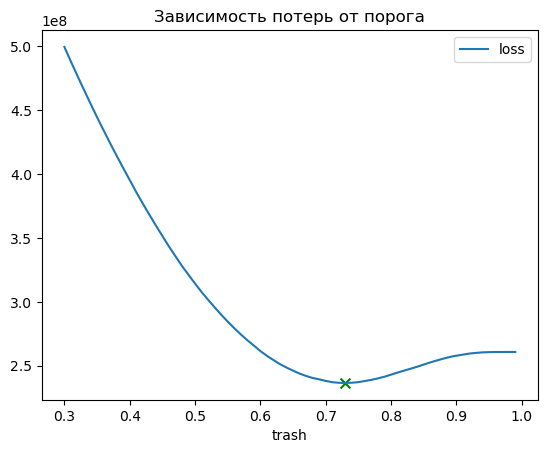

Оптимальный порог 0.73
Wall time: 14 s


In [39]:
%%time

# Определим оптимальный порог для средних параметров (беру, примерно, из статистики по РБ)
best_trsh, all_trash_df = trash(y_train, train_pred, 5000, .05, 18, 0.7)

# Посмотрим, как меняются потери в зависимости от порога
import matplotlib.pyplot as plt
all_trash_df.plot(x="trash", y='loss', title='Зависимость потерь от порога')
plt.scatter(best_trsh, 
            all_trash_df[all_trash_df.trash==best_trsh]['loss'],
            color='green',
            s=50,
            marker='x')
plt.show()

print('Оптимальный порог', round(best_trsh, 2))

#### Посмотрим, как меняется матрица ошибок при переходе к оптимальному порогу

In [40]:
print("confusion_matrix с порогом по умолчанию")
print(confusion_matrix(y_test, test_pred>0.5))
print('')
print("confusion_matrix с оптимальным порогом")
print(confusion_matrix(y_test, test_pred>best_trsh))

confusion_matrix с порогом по умолчанию
[[594251 273816]
 [  9496  22437]]

confusion_matrix с оптимальным порогом
[[810505  57562]
 [ 23160   8773]]


Видим существенный (в 2,4 раза или на 13,7 тыс.штук) рост выдачи проблемных кредитов.

Однако связанные с этим потери компенсируются доходом, получаемым от роста выдачи хороших кредитов
на 36% (на 216,3 тыс. штук)

In [53]:
print('Потери при выдаче всем клиентам:', '{:,}'.format(all_trash_df.iloc[0].loss).replace(',', ' '))
print('Потери с порогом 0.5:', '{:,}'.format(all_trash_df.iloc[20].loss).replace(',', ' '))
print('Потери с оптимальным порогом:', '{:,}'.format(all_trash_df.iloc[43].loss).replace(',', ' '))
print()
print('По сравнению с порогом по умолчанию потери сокращены на', round((1 - all_trash_df.iloc[43].loss / all_trash_df.iloc[20].loss) * 100, 2), '%')
print('По сравнению с порогом по умолчанию потери сокращены на', all_trash_df.iloc[20].loss - all_trash_df.iloc[43].loss, 'рублей')


Потери при выдаче всем клиентам: 499 267 625.0
Потери с порогом 0.5: 314 241 875.0
Потери с оптимальным порогом: 236 581 500.0

По сравнению с порогом по умолчанию потери сокращены на 24.71 %
По сравнению с порогом по умолчанию потери сокращены на 77660375.0 рублей


Подбор порога сокращает потери более, чем на 24% по сравнению с порогом по умолчанию

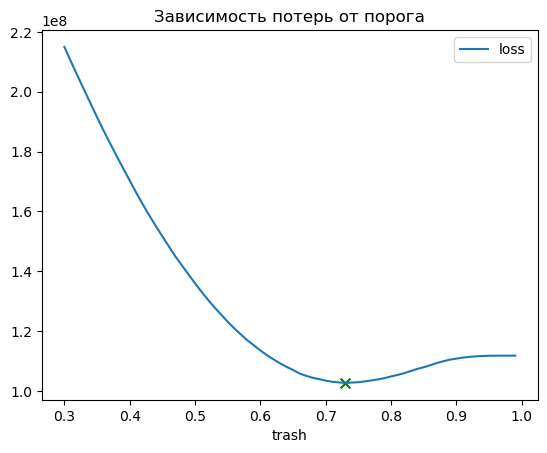

Оптимальный порог 0.73


In [54]:
# Проверим на тесте, что бы убедиться, что эффективность порога сохраняется
best_trsh_test, all_trash_df_test = trash(y_test, test_pred, 5000, .05, 18, 0.7)

# Посмотрим, как меняются потери в зависимости от порога
import matplotlib.pyplot as plt
all_trash_df_test.plot(x="trash", y='loss', title='Зависимость потерь от порога')
plt.scatter(best_trsh_test, 
            all_trash_df_test[all_trash_df.trash==best_trsh_test]['loss'],
            color='green',
            s=50,
            marker='x')
plt.show()

print('Оптимальный порог', round(best_trsh_test, 2))

Значение порога близко к порогу, расчитанному на train, можно предположить, что оно достаточно устойчиво.

In [56]:
# Сохраняем итоговые результаты в файл

final_model = {'type': 'CatBoostClassifier',
               'version': '1.0',
               'date': datetime.now().date(),
               'author': 'Короб Владимир',
               'model': best_model[0],
               'columns': best_model[1],
               'trash': best_trsh,
               'description': 'Итоговый проект курса «Machine Learning Junior»'
              }


import pickle
pkl_filename = "final_model_01_20230909.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)